In [1]:
import asyncio
import functools
import logging
import os
import re
import string
import time
import warnings

import folium
import numpy as np
import pandas as pd
import plotly.express as px
import pymongo
import spacy
from dotenv import load_dotenv
from folium import Marker
from folium.plugins import MarkerCluster
from nltk.corpus import stopwords

from utils.utils import get_coordinates
from utils.utils import get_job_industries

nlp = spacy.load('fr_core_news_sm')
stop = set(stopwords.words('french'))
exclude = set(string.punctuation) 
warnings.filterwarnings("ignore")

load_dotenv('database/.env')
bayt_collection_name = os.getenv('Bayt_collection')
tanit_collection_name = os.getenv('Tanit_collection')

MONGO_URI = os.getenv('MONGODB_URI')
DB_NAME = os.getenv('DATABASE_NAME')

client = pymongo.MongoClient(MONGO_URI)
db = client.get_database(DB_NAME)

tanit = db[tanit_collection_name]
bayt = db[bayt_collection_name]


In [2]:
MAX_AUTO_RECONNECT_ATTEMPTS = 5

def graceful_auto_reconnect(mongo_op_func):
  """Gracefully handle a reconnection event."""
  @functools.wraps(mongo_op_func)
  def wrapper(*args, **kwargs):
    for attempt in range(MAX_AUTO_RECONNECT_ATTEMPTS):
      try:
        return mongo_op_func(*args, **kwargs)
      except pymongo.errors.AutoReconnect as e:
        wait_t = 0.5 * pow(2, attempt) # exponential back off
        logging.warning("PyMongo auto-reconnecting... %s. Waiting %.1f seconds.", str(e), wait_t)
        time.sleep(wait_t)

  return wrapper


@graceful_auto_reconnect
def read_db(db):
    tanit_df = pd.DataFrame(iter(tanit.find()))
    return tanit_df


tanit_df = read_db(tanit)

# <b>Pre-Processing</b>

Deleting '_id' column created by mongoDB, renaming a few columns and doing simple type conversions

In [3]:
experience_map = {'Débutant':'No experience','0 à 1 an':'0-1 year','1 à 3 ans':'1-3 years','3 à 5 ans':'3-5 years','5 à 10 ans':'5-10 years','plus 10 ans':'10+ years'}
experience_order = ['No experience','0-1 year','1-3 years','3-5 years','5-10 years','10+ years']
salary_map = {'Inférieur à 500 DT':"0-500 DT",
             "Entre 500 DT et 1000 DT":"500-1000 DT",
             "Entre 1000 DT et 1500 DT":"1000-1500 DT",
             "Entre 1500 DT et 2000 DT":"1500-2000 DT",
             "Entre 2000 DT et 3000 DT":"2000-3000 DT",
             "Plus 3000 DT":"3000+ DT"}
salary_order=["0-500 DT","500-1000 DT","1000-1500 DT","1500-2000 DT","2000-3000 DT","3000+ DT"]
del tanit_df['_id']

tanit_df.rename(columns=
          {
              'Description de l\'emploi': 'Description',
              'Exigences de l\'emploi' : 'Requirements',
              'Date d\'expiration' : 'Expiration Date',
              'Rémunération proposée' : 'Salary Range',
              'Postes vacants':'Openings',
              "Niveau d'étude":"education levels",
              'Langue':'Language',
              "Type d'emploi désiré":"Employment Type"
          }, inplace=True)
tanit_df['posting_date'] = pd.to_datetime(tanit_df['posting_date'], format='%d/%m/%Y')
tanit_df['Expiration Date'] = pd.to_datetime(tanit_df['Expiration Date'], format='%d/%m/%Y')

tanit_df['Experience'] = tanit_df['Experience'].map(experience_map)
tanit_df['Experience'] = pd.Categorical(tanit_df['Experience'], categories=experience_order, ordered=True)

tanit_df['Salary Range'] = tanit_df['Salary Range'].map(salary_map)
tanit_df['Salary Range'] = pd.Categorical(tanit_df['Salary Range'], categories=salary_order, ordered=True)
tanit_df['Language_list'] = tanit_df['Language'].str.split(', ')
tanit_df['contract_types'] = tanit_df["Employment Type"].str.split(', ')
tanit_df['education_levels'] = tanit_df["education levels"].str.split(', ')

<h3> <b>Extracting the number of available openings of a particular job</b>

In [4]:
job_openings = tanit_df['Openings'].map(lambda poste: re.search(r'\d', poste).group()).astype('int32')
tanit_df['Openings'] = job_openings

<h3> <b>Text data clean up (Punctuation, stop words, special characters removal)</b>

In [5]:
def clean(doc):
    if not(type(doc) in [np.nan,np.NAN,np.NaN,float,"",None]):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        only_alphabet = ''.join([c for c in punc_free if c.isalpha() or c == ' '])
        
        return only_alphabet
    return None


tanit_df['Description'] = tanit_df['Description'].fillna('').map(lambda x: clean(x)).apply(lambda x: x.lower())
tanit_df['Requirements'] = tanit_df['Requirements'].fillna('').map(lambda x: clean(x)).apply(lambda x: x.lower())
tanit_df['Title'].map(lambda x: x.encode('ascii',"ignore").decode())

0                    Chef d'agence immobiliere a Boumhel
1       Assistante Administrative cit la ghazela- Ariana
2                                     Graphique Designer
3                 Agente Immobilier Exprimente a Boumhel
4              Ngociateurs Et Agents en Immobilier (H/F)
                              ...                       
6024                                    Team leader Paie
6025                                      Aide Comptable
6026                                  Designer Graphique
6027           Ingnieur Dveloppement Senior Java - Tunis
6028                              Assistante Commerciale
Name: Title, Length: 6029, dtype: object

<h3><b> Converting 'Zone' data into latitude and longitude using a geocoding API (implementation in utils) </b>

In [6]:
tanit_df['Zone'] = tanit_df['Zone'].map(lambda x: x.encode('ascii',"ignore").decode())
loop = asyncio.get_event_loop()
task = loop.create_task(get_coordinates(tanit_df))
coordinates = await task
tanit_df = tanit_df.merge(coordinates, on='Zone', how='left')
tanit_df['Latitude'] = tanit_df['Latitude'].astype(float)
tanit_df['Longitude'] = tanit_df['Longitude'].astype(float) 

('Tunis, Tunis, Tunisie', '10.1857757', '36.8002068')
('Sousse, Sousse, Tunisie', '10.6405392', '35.8288175')
('Sfax, Sfax, Tunisie', '10.7604024', '34.7394361')
('Centre Urbain Nord, Tunis, Tunisie', '10.1912271', '36.8507941')
('Ariana, Ariana, Tunisie', '10.188232', '36.8587351')
('Montplaisir, Tunis, Tunisie', '10.1863745', '36.8170312')
('Les Berges du Lac 1, Tunis, Tunisie', '10.237317908277824', '36.83514665')
('Ben Arous, Ben Arous, Tunisie', '10.2245072', '36.7516855')
('Monastir, Monastir, Tunisie', '10.8280511', '35.7707582')
('Les Berges du Lac 2, Tunis, Tunisie', '10.237317908277824', '36.83514665')
('La Soukra, Ariana, Tunisie', '10.2454267', '36.8749751')
('La Charguia II, Tunis, Tunisie', '10.2611996', '36.8479251')
('La Charguia I, Tunis, Tunisie', '10.2009317', '36.830707')
('Nabeul, Nabeul, Tunisie', '10.7355915', '36.4512897')
('Hammamet, Nabeul, Tunisie', '10.6190626', '36.4006557')
('La Marsa,Tunis, Tunisie', '10.327678', '36.8790882')
('Zone Industrielle El Mghir

<h3> <b>Extraction of broad job categories using Llama3 API (implementation in utils) </b>

In [7]:
loop = asyncio.get_event_loop()
task = loop.create_task(get_job_industries(tanit_df))
task_result = await task
tanit_df['Category'] = tanit_df['Title'].map(task_result)
keep_categories = ['Administration/Management', 'Sales', 'Tradesperson', 'Software/IT',
       'Engineering', 'Arts & Design', 'Customer Service', 'Finance',
       'Marketing', 'Healthcare', 'Accounting', 'Manufacturing']

total = tanit_df['Category'].value_counts().sum()
categories = tanit_df['Category'].value_counts()
tanit_df['Category'] = tanit_df['Category'].apply(lambda x: x if pd.notna(x) and ((x in keep_categories) or (categories[x] / total > 0.02)) else 'Other')

Progress: length(99)
Progress: length(198)
Progress: length(298)
Progress: length(397)
Progress: length(496)
Progress: length(596)
Progress: length(696)
Progress: length(795)
Progress: length(893)
Progress: length(992)
Progress: length(1091)
Progress: length(1192)
Progress: length(1292)
Progress: length(1392)
Progress: length(1492)
Progress: length(1591)
Progress: length(1691)
Progress: length(1791)
Progress: length(1884)
Progress: length(1984)
Progress: length(2083)
Progress: length(2182)
Progress: length(2282)
Progress: length(2382)
Progress: length(2480)
Progress: length(2579)
Progress: length(2677)
Progress: length(2777)
Progress: length(2877)
Progress: length(2975)
Progress: length(3075)
Progress: length(3175)
Progress: length(3274)
Progress: length(3373)
Progress: length(3472)
Progress: length(3572)
Progress: length(3672)
Progress: length(3772)
Progress: length(3872)
Progress: length(3972)
Progress: length(4072)
Progress: length(4171)
Progress: length(4271)
Progress: length(4371)

<H3> <b>Distribution of job categories</b>

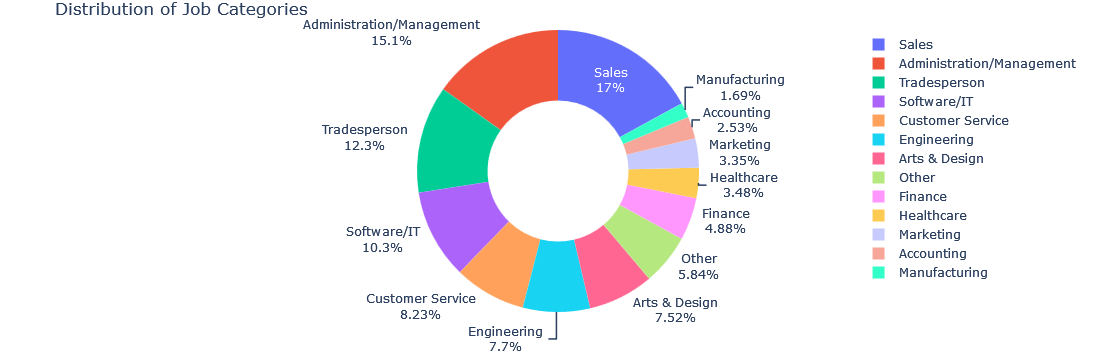

In [8]:
filtered_df = tanit_df[tanit_df['Category'].notna()]
category_counts = filtered_df.groupby('Category')['Openings'].sum()

category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Category', 'Count']

fig = px.pie(category_counts_df, values='Count', names='Category', title='Distribution of Job Categories',
             hole=0.5)

fig.update_traces(textinfo='percent+label') 
fig.update_layout(
    autosize=True,
    margin=dict(l=20, r=20, t=30, b=20),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig.show()

<h3> <b>Visualizing the concentration of jobs across the country.</b>

In [9]:
filtered_df = tanit_df[(tanit_df['Latitude'].notna()) & (tanit_df['Category'].notna())]
map = folium.Map(location=[36.806389, 10.181667], zoom_start=6,tiles ='cartodbpositron')
mc = MarkerCluster()
for idx, row in filtered_df.iterrows():
    mc.add_child(Marker([row['Latitude'], row['Longitude']]))
map.add_child(mc)

Unsurprisingly, Most jobs posted online are located on major coastal cities (Sousse, Monastir, Nabeul) and the capital Tunis.

<H3> <b>Analysis of salary information </b>

In [10]:
filtered_df = tanit_df[ (tanit_df['Salary Range'] != 'Confidentiel') & (tanit_df['Salary Range'].notna()) & (tanit_df['Category'] != 'Other')]

filtered_df = filtered_df.groupby(['Salary Range','Category']).size().reset_index(name='count')

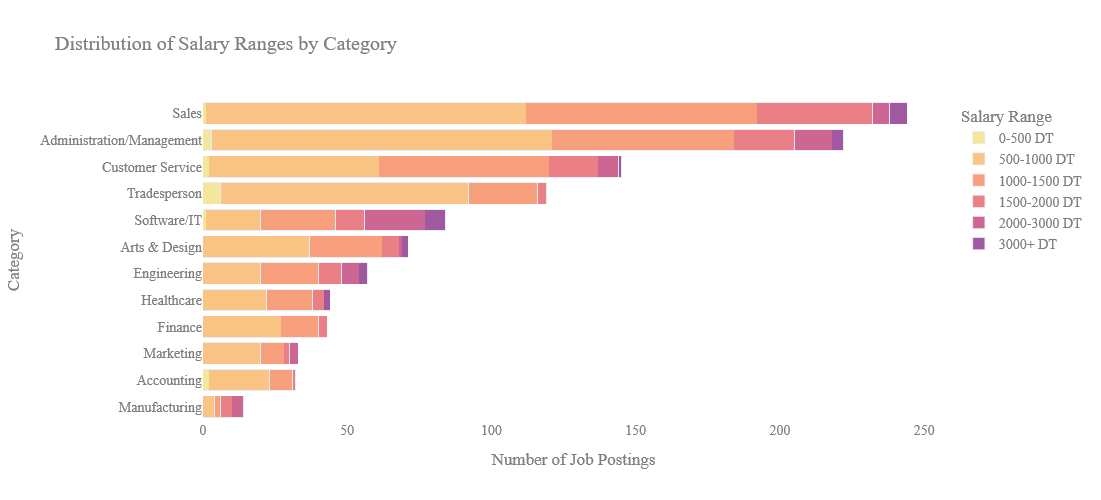

In [11]:

fig = px.bar(filtered_df, x='count', y='Category', color='Salary Range',
             title='Distribution of Salary Ranges by Category',
             barmode='stack',color_discrete_sequence = px.colors.sequential.Sunset)
fig.update_layout(
    autosize=True,
    xaxis_title='Number of Job Postings',
    yaxis_title='Category',
    legend_title='Salary Range',
    yaxis_type='category',
    font=dict(
        family='Times New Roman',
        size=14,
        color='#7f7f7f'
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=500  # Adjust the height as needed
    ,yaxis={'categoryorder':'total ascending'}
)

fig.show()



The graph shows the distribution of salary ranges across various job categories, highlighting that Sales and Administration/Management have the most job postings, predominantly offering lower salaries (500-1500 DT). Customer Service follows a similar trend. Tradesperson and Software/IT categories display a more balanced distribution across mid to higher salary ranges (1500-3000+ DT), with fewer postings overall. Specialized fields like Engineering, Healthcare, and Finance, though with fewer postings, offer higher salaries. This indicates that more specialized jobs tend to offer higher compensation compared to more common roles. However, many job postings do not include salary ranges, therefore this chart may not fully reflect the actual salary distribution across

<h3> <b>Most common language requirements across categories</b>

In [17]:
df = tanit_df.explode('Language_list')
language_counts = df.groupby(['Category', 'Language_list']).size().reset_index(name='Count')
language_counts= language_counts[(~language_counts['Category'].isin(['Other'])) & (language_counts['Language_list'].isin(['Arabe','Français','Anglais']))]

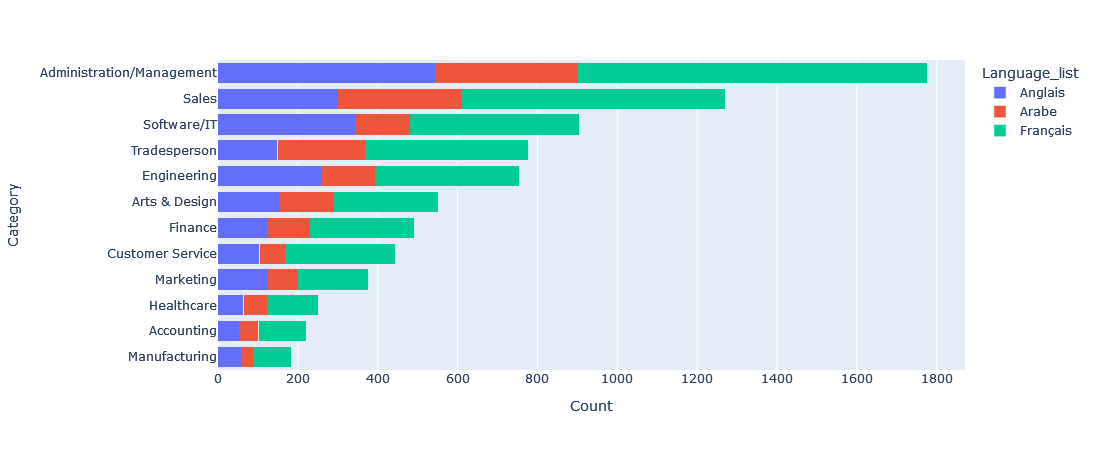

In [18]:

fig = px.bar(language_counts, x='Count', y='Category', color='Language_list', barmode='stack')
fig.update_layout(yaxis={'categoryorder':'total ascending'},height=450)
fig.show()

- As one would expect, french is still very much a requirement in certain fields (Management, Sales, Finance & Accounting, Customer Service, Trades etc..).
- Engineering and IT-related jobs show a notable demand for english proficiency.

<h3><b>Previous experience requirements across job categories</b></h3>

In [20]:
filtered_df = tanit_df[tanit_df['Category'] != 'Other']
experience_counts=filtered_df.groupby(['Category','Experience']).size().reset_index(name="count").

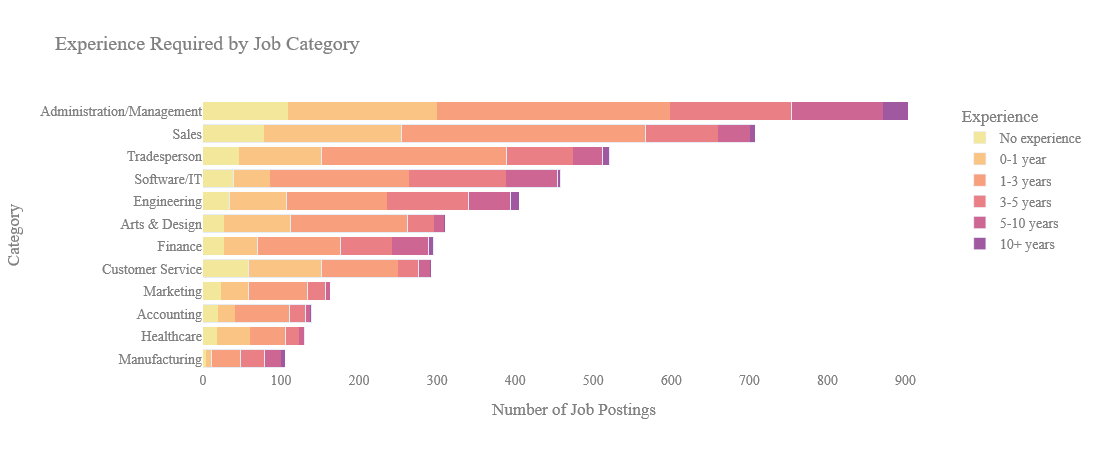

In [45]:

fig = px.bar(experience_counts, x='count', y='Category', color='Experience',
             title='Experience Required by Job Category',
             barmode='stack',color_discrete_sequence = px.colors.sequential.Sunset)
fig.update_layout(
    autosize=True,
    xaxis_title='Number of Job Postings',
    yaxis_title='Category',
    legend_title='Experience',
    yaxis_type='category',
    font=dict(
        family='Times New Roman',
        size=14,
        color='#7f7f7f'
    ),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=450 ,yaxis={'categoryorder':'total ascending'}
    
)

fig.show()



The plot reveals that most job categories require 1-3 years of experience, indicating a strong demand for candidates with early to mid-level experience. Certain fields such as IT, Engineering, and Finance roles are not very entry-level friendly, as they show fewer job postings for candidates with no experience or 0-1 years of experience.

<h3> <b> Entry-level/Internship postings timeline</b>

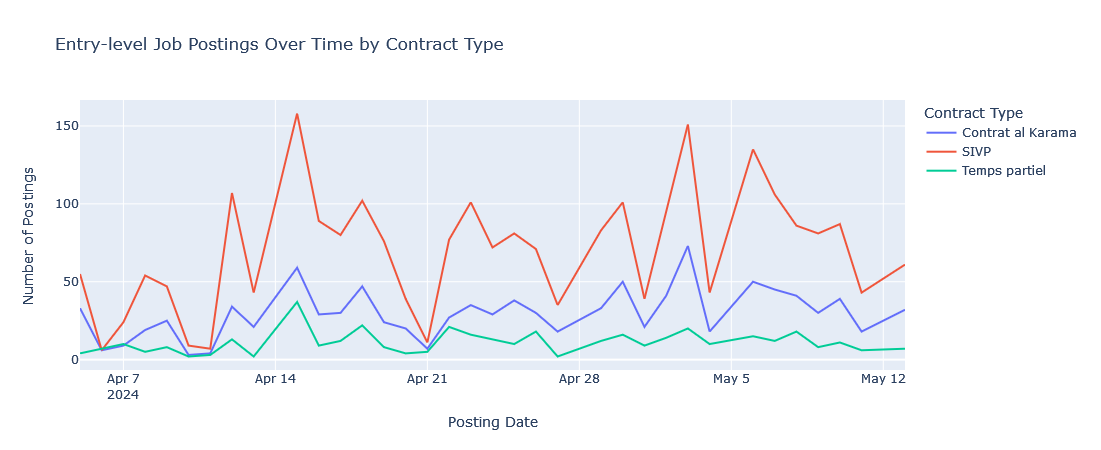

In [48]:
exploded_df = tanit_df.explode('contract_types')
grouped_df = exploded_df.groupby(['contract_types', 'posting_date']).size().reset_index(name='count')
grouped_df = grouped_df[grouped_df['contract_types'].isin(['SIVP','Contrat al Karama','Temps partiel'])]

fig = px.line(grouped_df, x='posting_date', y='count', color='contract_types',
              title='Entry-level Job Postings Over Time by Contract Type',
              labels={'posting_date': 'Posting Date', 'count': 'Number of Postings', 'contract_types': 'Contract Type'},height=450)

fig.update_layout(xaxis_title='Posting Date', yaxis_title='Number of Postings')

fig.show()

Internships/Part time jobs postings are more frequent in the middle of April and the start of May. 

<H3><b>Q: Do you need experience to land your first job out of university/Internship?</b>

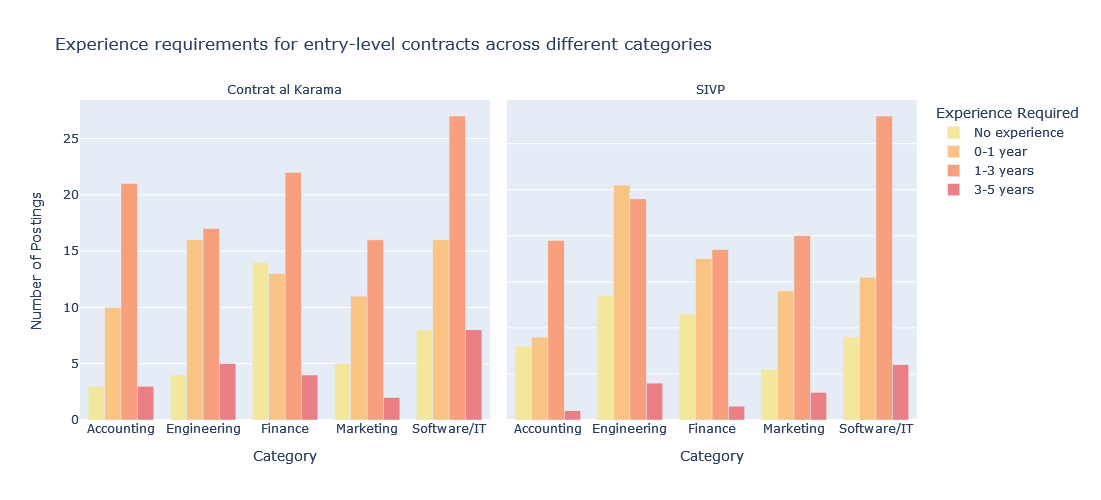

In [49]:
exploded_df = tanit_df.explode('contract_types')


internship_df = exploded_df[(exploded_df['Experience'].isin(['No experience','0-1 year','1-3 years','3-5 years']))&(exploded_df['contract_types'].isin(['SIVP','Contrat al Karama'])) & (exploded_df['Category'].isin(['Accounting','Finance','Engineering','Marketing','Software/IT'])) ]



grouped_df = internship_df.groupby(['Category', 'Experience','contract_types']).size().reset_index(name='count')
grouped_df = grouped_df[grouped_df['Experience'].isin(['No experience','0-1 year','1-3 years','3-5 years'])]

fig = px.bar(grouped_df, x='Category', y='count', color='Experience', barmode='group',facet_col='contract_types', 
             title='Experience requirements for entry-level contracts across different categories',
             labels={'Category': 'Category', 'count': 'Number of Postings', 'Experience': 'Experience Required'},height=500,color_discrete_sequence = px.colors.sequential.Sunset)

fig.update_layout(xaxis_title='Category', yaxis_title='Number of Postings')
fig.update_yaxes(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("contract_types=", "")))

fig.show()



Most job postings in categories like IT, Engineering, and Marketing require some level of experience (0-1 year and 1-3 years). In contrast, categories like finance offer more balanced opportunities across different experience levels, including those with no prior experience. In essence, There are relatively fewer opportunities for candidates with no experience, though these are still present in all categories.

<H3><b>Degree requirements by category</b>

In [50]:
ed_levels = tanit_df.explode("education_levels")
ed_levels1 = ed_levels.groupby(['Category','education_levels']).size().reset_index(name="count")

In [51]:
ed_levels1 = ed_levels1[(ed_levels1['education_levels'].isin(['Master','Ingénieur','Licence']))&(ed_levels1['Category'].isin(['Accounting','Finance','Engineering','Marketing','Software/IT']))]

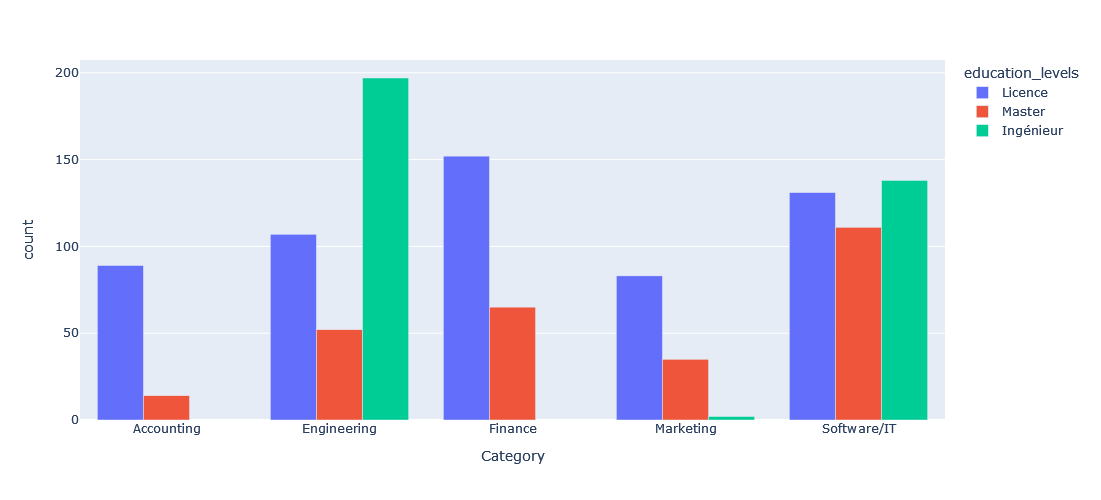

In [52]:
fig = px.bar(ed_levels1, y='count', x='Category', color='education_levels', barmode='group')
fig.update_layout(yaxis={'categoryorder':'total ascending'},height=500)
fig.show()

- Most postings in Accounting, Finance, Marketing require a Bachelor's, with few needing a Master’s degree. 
- Classical Engineering disciplines are accessible with a Bachelors. However, Engineering Diplomas are heavily favored. There does not seem to be much benefit from acquiring a Master's in a classical engineering field.
- Software/IT: Although there are good prospects for both Bachelor and Master's degrees holders, more emphasis and preference is placed on engineering degree holders. 

<h3><b>Salaries by degree type across industries </b></h3>

In [84]:
filtered_df = ed_levels[(ed_levels['Category'].isin(['Finance','Engineering','Marketing','Software/IT']))&(ed_levels['education_levels'].isin(['Master','Ingénieur','Licence',"Grandes Ecoles"]))&(ed_levels["Salary Range"] != "Confidentiel")]
filtered_df['Experience'] = filtered_df['Experience'].map(experience_map)
desired_order = ['No experience','0-1 year','1-3 years','3-5 years','5-10 years','10+ years']
filtered_df['Experience'] = pd.Categorical(filtered_df['Experience'], categories=desired_order, ordered=True)

filtered_df['Experience'] = filtered_df['Experience'].cat.reorder_categories(desired_order)
filtered_df = filtered_df.groupby(['Category','Salary Range','education_levels']).size().reset_index(name="count")

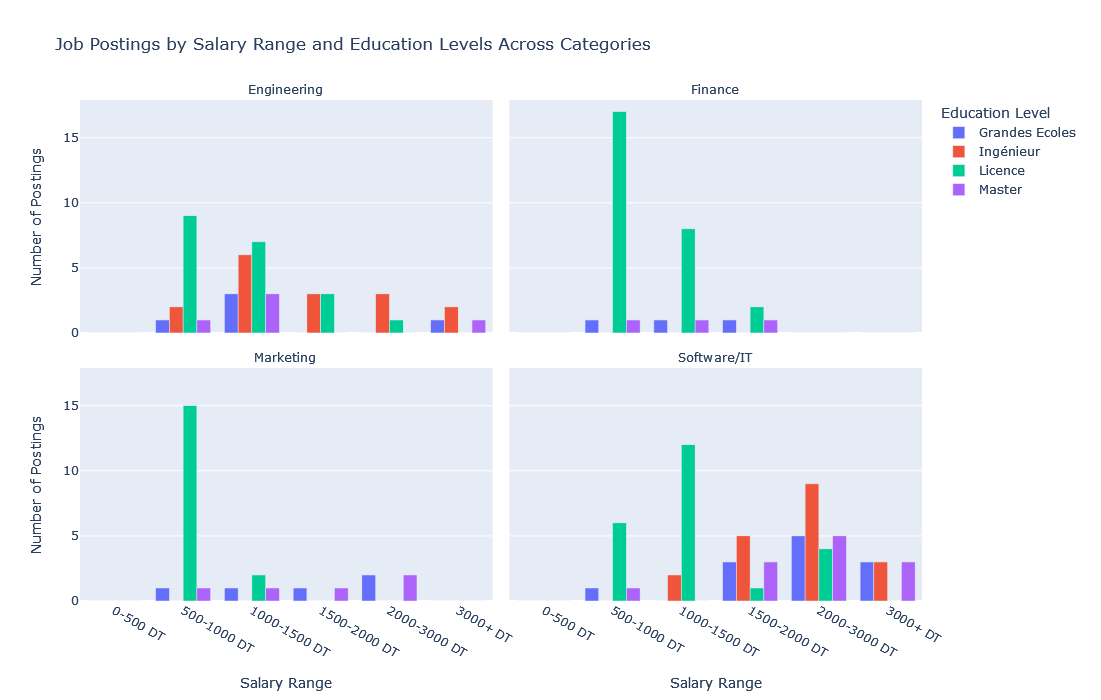

In [88]:
fig = px.bar(filtered_df, x='Salary Range', y='count', color='education_levels', barmode='group', facet_col='Category',
             title='Job Postings by Salary Range and Education Levels Across Categories',facet_col_wrap=2,
             labels={'Salary Range': 'Salary Range', 'count': 'Number of Postings', 'education_levels': 'Education Level', 'Category': 'Category'})

fig.update_layout(
    autosize=True,
    yaxis={'categoryorder': 'total ascending'},
    height=700
)
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("Category=", "")))
fig.show()

- Finance and Marketing: Master's degrees seem to be a requirement for higher pay. Schools don't have much influence on salary.
- Engineering: Engineering diploma looks to be the main requirement for higher pay. Preference for elite institutions doesn't seem to factor in that in the mid to high pay brackets.
- Software/IT: Master's degrees and engineering diplomas seem to yield similar returns. Preference for elite institutions is significant for high-paying jobs.

<h3><b>Software/IT Frameworks Requirements</b></h3>

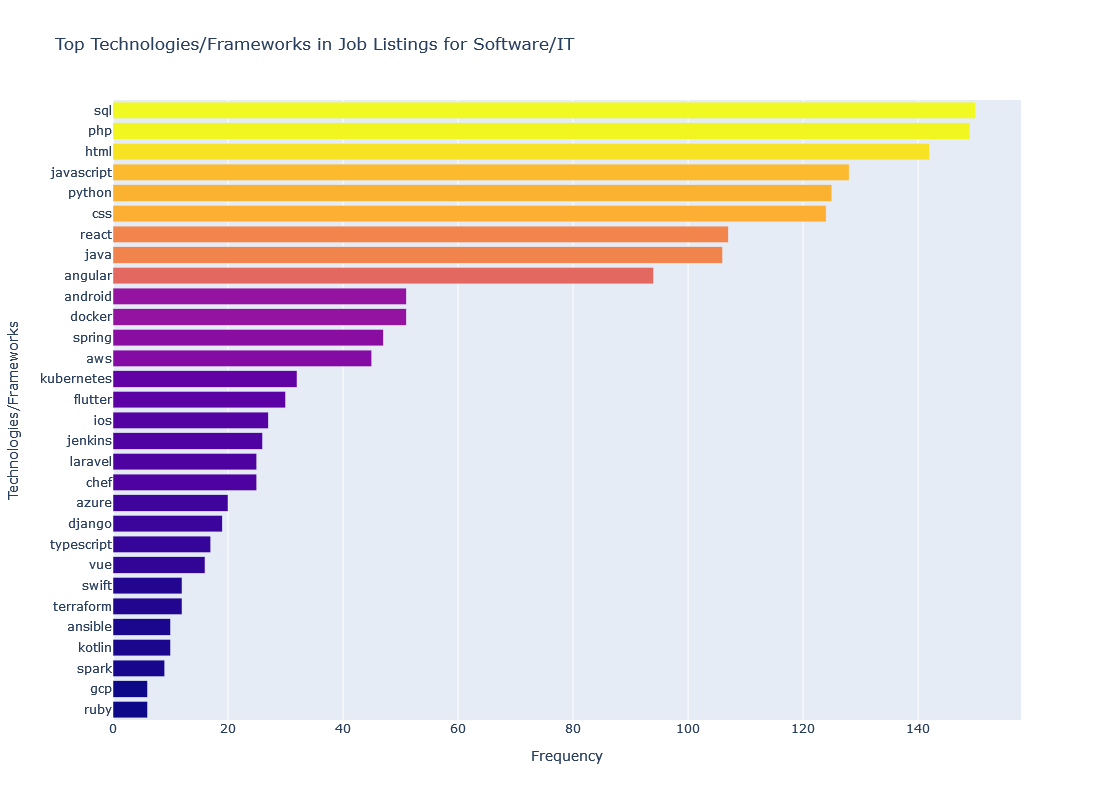

In [26]:
programming_keywords = {
    'python', 'java', 'javascript', 'c++', 'c#', 'ruby', 'php', 'swift', 'kotlin', 
    'typescript', 'go', 'r', 'scala', 'perl', 'rust', 'dart', 'matlab', 'html', 
    'css', 'sql', 'node.js', 'react', 'angular', 'vue', 'django', 'flask', 'spring', 
    'rails', 'laravel', 'asp.net', 'tensorflow', 'pytorch', 'keras', 'theano', 
    'hadoop', 'spark', 'scikit-learn', 'pandas', 'numpy', 'xgboost', 'lightgbm', 
    'aws', 'azure', 'gcp', 'google cloud', 'amazon web services', 'microsoft azure', 
    'docker', 'kubernetes', 'terraform', 'ansible', 'jenkins', 'puppet', 'chef',
    'android', 'ios', 'react native', 'flutter', 'xamarin', 'cordova', 'ionic', 'objective-c'
}

def extract_keywords(text):
    doc = nlp(text.lower())
    relevant_words = [token.text for token in doc if token.text in programming_keywords]
    return relevant_words

category = 'Software/IT'
filtered_df = tanit_df[tanit_df['Category'] == category]

filtered_df['combined_text'] = (
    filtered_df['Title'].fillna('') + ' ' +
    filtered_df['Description'].fillna('') + ' ' +
    filtered_df['Requirements'].fillna('')
)

filtered_df['keywords'] = filtered_df['combined_text'].apply(lambda x: extract_keywords(str(x)))

exploded_df = filtered_df.explode('keywords')

keyword_counts = exploded_df['keywords'].value_counts().reset_index()
keyword_counts.columns = ['keyword', 'count']

top_keywords = keyword_counts.head(30)

fig = px.bar(top_keywords, x='count', y='keyword', orientation='h',
             title=f'Top Technologies/Frameworks in Job Listings for {category}',
             labels={'count': 'Frequency', 'keyword': 'Technologies/Frameworks'},
             color='count')

fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Technologies/Frameworks',
    yaxis={'categoryorder': 'total ascending'},
    coloraxis_showscale=False,
    height=800,
)

fig.show()

high demand for web development skills like SQL, PHP, HTML, JavaScript, and Python. React and Angular indicate a need for modern web applications.
Docker, AWS, azure indicate demand for cloud and devops engineers. Mobile app development is also in demand (java, android, flutter). The market for AI and Machine Learning has not flourished yet.